In [1]:
import copy
import time
import gc
import os
import sys
import torch
import torch.optim as optim
import torchvision
from torchvision.models import vit_b_16
from torch.utils.data import DataLoader

In [2]:
# Custom imports assuming they are in the parent directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from data_utils import Transform
from models import Decoder, MaskedAutoEncoder
from losses import dice_loss
from metrics import pixel_wise_accuracy, evaluate_model_performance
from utils import test_visualization

In [3]:
# Configuration for datasets
batch_size = 64
dataset_config = {
    'image_size': (224, 224),
    'data_path': '../datasets/data',
    'aug_data_path': '../datasets/aug_data'
}

# Split configurations for fine-tuning
fine_tune_dataset_split = {
    'use_data_ratio': 0.1, # Fine-tuning the use ratio of the dataset
    'train_ratio': 0.8,  # Fine-tuning the scale of the training dataset
    'test_ratio': 0.2, #Fine-tuning the scale of the test dataset
}

# Training configuration for fine-tuning
fine_tune_training_config = {
    'batch_size': 64, 
    'shuffle_train': True,  
    'shuffle_test': False,
    'training_epochs' : 20, # Fine-tuning phase training epochs
    'learning_rate': 1e-4 # Learning rate in the pre-training phase
}

# Pre-training weights for the vit_b_16 model are used directly

In [4]:
# Setup model and training devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = vit_b_16(pretrained=True).to(device)
decoder = Decoder(1000, 512, 3 * 224 * 224).to(device)
pre_model = MaskedAutoEncoder(encoder, decoder).to(device)
# optimizer = optim.Adam(pre_model.parameters(), lr=pre_train['learning_rate'])
mask = torch.rand(size=(1, 3, 224, 224)) > 0.5
mask = mask.to(device)
scaler = torch.cuda.amp.GradScaler()

/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Fine-tuning of pre-trained models

In [5]:
# When initializing your OxfordIIITPet dataset, you can use:
transform = Transform(image_size = dataset_config['image_size'])
full_dataset = torchvision.datasets.OxfordIIITPet(root='../datasets',
                        target_types='segmentation',
                        transforms=transform,
                        download=True)


# Define the size of training and testing datasets
total_size = len(full_dataset)
used_data_size = int(total_size * fine_tune_dataset_split['use_data_ratio'])
train_size = int(used_data_size * fine_tune_dataset_split['train_ratio'])
test_size = used_data_size - train_size

# Split the dataset
indices = torch.randperm(total_size).tolist()
used_indices = indices[:used_data_size]
train_indices = used_indices[:train_size]
test_indices = used_indices[train_size:]

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)


print(f"Fine-tuning Original dataset size: {total_size}")
print(f"Fine-tuning Used dataset size: {used_data_size} ({fine_tune_dataset_split['use_data_ratio']*100}%)")
print(f"Fine-tuning Training dataset size: {len(train_dataset)}")
print(f"Fine-tuning Testing dataset size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=fine_tune_training_config['batch_size'], shuffle=fine_tune_training_config['shuffle_train'], drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=fine_tune_training_config['shuffle_test'], drop_last=True)

Fine-tuning Original dataset size: 3680
Fine-tuning Used dataset size: 368 (10.0%)
Fine-tuning Training dataset size: 294
Fine-tuning Testing dataset size: 74


In [6]:
evaluate_model_performance(pre_model, test_loader, device, mask, "the pre-trained model")

Accuracy of the pre-trained model on the fine-tuning test dataset: 0.33
IoU score of the pre-trained model on the fine-tuning test dataset: 0.18


In [7]:
# Initialize mask and model for fine-tuning
mask = torch.ones(size=(1, 3, 224, 224)).to(device)
fine_model_with_pre = copy.deepcopy(pre_model).to(device)  # Use deepcopy to ensure that the weights of pre_model remain unchanged
optimizer = optim.Adam(fine_model_with_pre.parameters(),
                       lr=fine_tune_training_config['learning_rate'])

# Start the fine-tuning process
print("Starting the fine-tuning process with the pre-trained model...")

for epoch in range(fine_tune_training_config['training_epochs']):
    start_time = time.time()
    fine_model_with_pre.train()  # Ensure the model is in training mode
    total_loss = 0.0
    total_batches = 0
    for i, (x, y) in enumerate(train_loader):
        inputs, targets = x.to(device), y.to(device)
        optimizer.zero_grad()

        # Generate predictions using the fine-tuned model
        preds = fine_model_with_pre(inputs, mask)
        if preds.size(0) == inputs.size(0):
            batch_size = preds.shape[0]
            preds = preds.reshape(batch_size, 3, 224, 224)

            # Compute the loss and accuracy
            loss = dice_loss(preds, targets)
            accuracy = pixel_wise_accuracy(preds, targets)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Accumulate loss
            total_loss += loss.item()
            total_batches += 1
            
            # Print batch loss
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item():.3f}, Accuracy: {accuracy:.3f}')

    average_loss = total_loss / total_batches if total_batches > 0 else 0
    end_time = time.time()
    epoch_duration = end_time - start_time

    # Print epoch results
    print(f'Epoch {epoch+1} completed, Average Loss: {average_loss:.3f}, Duration: {epoch_duration:.2f} seconds------------------------------------')

print("Fine-tuning completed.")

Starting the fine-tuning process with the pre-trained model...
Epoch 1, Batch 1, Loss: 0.704, Accuracy: 0.333
Epoch 1, Batch 2, Loss: 0.704, Accuracy: 0.351
Epoch 1, Batch 3, Loss: 0.700, Accuracy: 0.367
Epoch 1, Batch 4, Loss: 0.688, Accuracy: 0.383
Epoch 1 completed, Average Loss: 0.699, Duration: 2.57 seconds------------------------------------
Epoch 2, Batch 1, Loss: 0.686, Accuracy: 0.401
Epoch 2, Batch 2, Loss: 0.675, Accuracy: 0.422
Epoch 2, Batch 3, Loss: 0.668, Accuracy: 0.439
Epoch 2, Batch 4, Loss: 0.651, Accuracy: 0.459
Epoch 2 completed, Average Loss: 0.670, Duration: 2.49 seconds------------------------------------
Epoch 3, Batch 1, Loss: 0.639, Accuracy: 0.489
Epoch 3, Batch 2, Loss: 0.633, Accuracy: 0.499
Epoch 3, Batch 3, Loss: 0.617, Accuracy: 0.513
Epoch 3, Batch 4, Loss: 0.601, Accuracy: 0.535
Epoch 3 completed, Average Loss: 0.623, Duration: 2.49 seconds------------------------------------
Epoch 4, Batch 1, Loss: 0.587, Accuracy: 0.557
Epoch 4, Batch 2, Loss: 0.570

Accuracy of the fine-tuned model on the fine-tuning test dataset: 0.62
IoU score of the fine-tuned model on the fine-tuning test dataset: 0.37


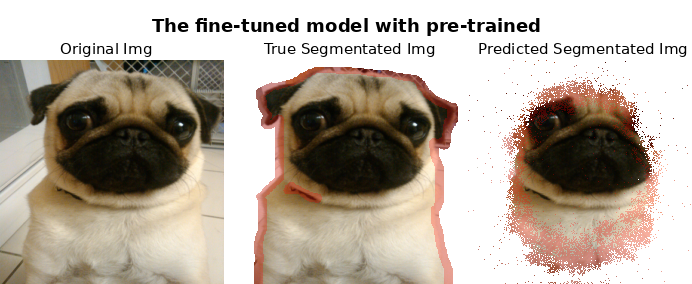

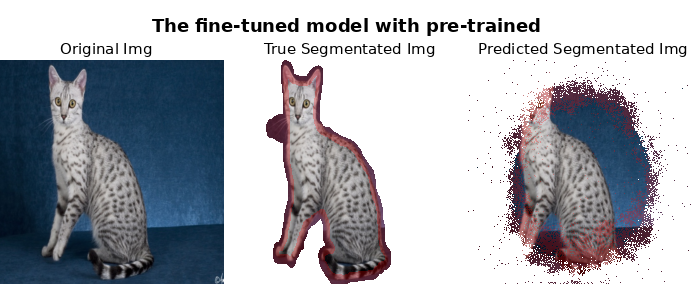

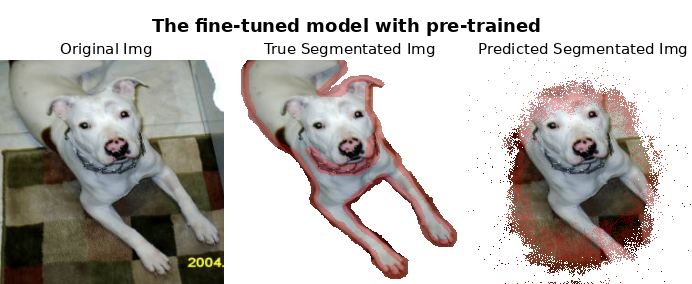

0

In [8]:
evaluate_model_performance(fine_model_with_pre, test_loader, device, mask, "the fine-tuned model")

test_visualization(fine_model_with_pre, test_loader, mask, device, f"The fine-tuned model with pre-trained", "../images/compare_pretrained_with_baseline")

# Freeing up graphics card memory
fine_model_with_pre.to('cpu')
torch.cuda.empty_cache()  
gc.collect()

# Fine-tuning from scratch models (baseline models)

In [9]:
# Fine-tuning from scratch models (baseline models)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the baseline model components
encoder = vit_b_16(pretrained=False).to(device)
decoder = Decoder(1000, 512, 3*224*224).to(device)
fine_model_without_pre = MaskedAutoEncoder(encoder, decoder).to(device)
mask = torch.ones(size=(1, 3, 224, 224))
mask = mask.to(device)
# Set up the optimizer for the baseline model
optimizer = optim.Adam(fine_model_without_pre.parameters(),
                       lr=fine_tune_training_config['learning_rate'])

# Start training the baseline model
print("Starting training of the baseline model without pre-trained weights...")

for epoch in range(fine_tune_training_config['training_epochs']):
    start_time = time.time()
    fine_model_without_pre.train()  # Ensure the model is in training mode
    total_loss = 0.0
    total_batches = 0
    for i, (x, y) in enumerate(train_loader):
        inputs, targets = x.to("cuda"), y.to("cuda")
        optimizer.zero_grad()

        # Forward pass
        preds = fine_model_without_pre(inputs, mask)
        if preds.size(0) == inputs.size(0):
            batch_size = preds.shape[0]
            preds = preds.reshape(batch_size, 3, 224, 224)

            # Compute loss and accuracy
            loss = dice_loss(preds, targets)
            accuracy = pixel_wise_accuracy(preds, targets)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Accumulate loss
            total_loss += loss.item()
            total_batches += 1
            
            # Print batch loss
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item():.3f}, Accuracy: {accuracy:.3f}')

    average_loss = total_loss / total_batches if total_batches > 0 else 0
    end_time = time.time()
    epoch_duration = end_time - start_time

    # Print training progress
    print(f'Epoch {epoch+1} completed, Average Loss: {average_loss:.3f}, Duration: {epoch_duration:.2f} seconds------------------------------------')

print("Baseline model without pre-trained weights training completed.")

/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting training of the baseline model without pre-trained weights...
Epoch 1, Batch 1, Loss: 0.708, Accuracy: 0.335
Epoch 1, Batch 2, Loss: 0.706, Accuracy: 0.345
Epoch 1, Batch 3, Loss: 0.704, Accuracy: 0.359
Epoch 1, Batch 4, Loss: 0.704, Accuracy: 0.370
Epoch 1 completed, Average Loss: 0.705, Duration: 2.48 seconds------------------------------------
Epoch 2, Batch 1, Loss: 0.704, Accuracy: 0.383
Epoch 2, Batch 2, Loss: 0.698, Accuracy: 0.399
Epoch 2, Batch 3, Loss: 0.695, Accuracy: 0.415
Epoch 2, Batch 4, Loss: 0.694, Accuracy: 0.432
Epoch 2 completed, Average Loss: 0.698, Duration: 2.45 seconds------------------------------------
Epoch 3, Batch 1, Loss: 0.691, Accuracy: 0.445
Epoch 3, Batch 2, Loss: 0.678, Accuracy: 0.459
Epoch 3, Batch 3, Loss: 0.669, Accuracy: 0.490
Epoch 3, Batch 4, Loss: 0.660, Accuracy: 0.499
Epoch 3 completed, Average Loss: 0.674, Duration: 2.48 seconds------------------------------------
Epoch 4, Batch 1, Loss: 0.657, Accuracy: 0.508
Epoch 4, Batch 2, Los

In [10]:
evaluate_model_performance(fine_model_without_pre, test_loader, device, mask, "the baseline model without pre-trained")

Accuracy of the baseline model without pre-trained on the fine-tuning test dataset: 0.62
IoU score of the baseline model without pre-trained on the fine-tuning test dataset: 0.37


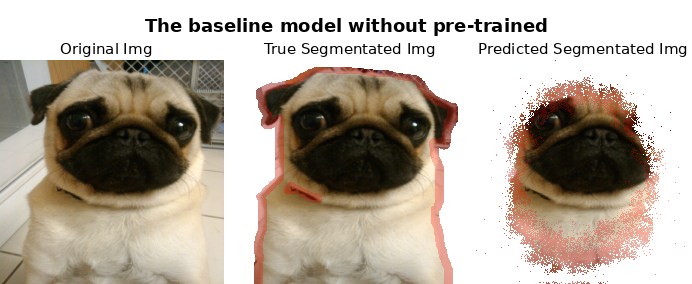

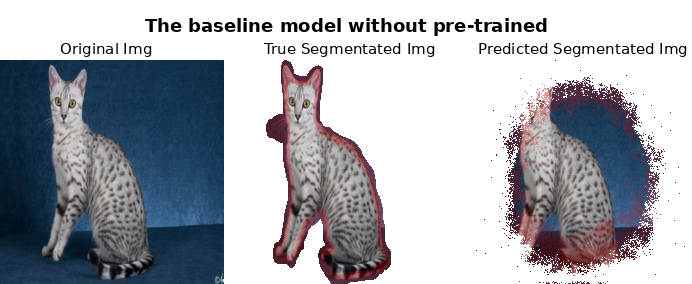

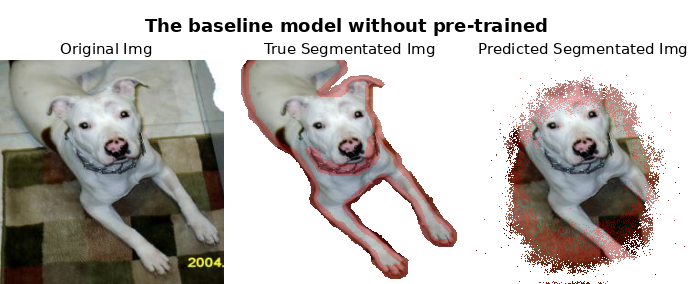

In [11]:
test_visualization(fine_model_without_pre, test_loader, mask, device, f"The baseline model without pre-trained", "../images/compare_pretrained_with_baseline")